# Harringtonine CropArray Example

---

## Notebook summary 


- Load a microscope image of video
- Tracking spots on the image and generate a pandas dataframe with the spots locations
- Creating a croparray with the image and dataframe
- Signal quantification and plotting
- Visualization of croparray with Napari

----

## Importing libraries


----

In [1]:
# To manipulate arrays
import numpy as np 
from skimage.io import imread
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()  
import pathlib # for working with windows paths
import sys
import cv2
import trackpy as tp
#!pip install shapely
from shapely.geometry import Polygon 
from shapely.geometry import Point
current_dir = pathlib.Path().absolute()
croparray_dir = current_dir.parents[0].joinpath('croparray')
sys.path.append(str(croparray_dir))
import crop_array_tools as ca
# %matplotlib inline 
plt.style.use('dark_background')

In [2]:
# Napari 
%gui qt5 
import napari
from napari.utils import nbscreenshot

## Parameters for quantification


----

In [3]:
# Data filename and directory
dir = r'X:\Tim'
dir = r'Z:\galindo\1_Imaging_Data\20220210_metabolites\PEP_10mM'
#img_4D_max_filename = r'MAX_Chamber02_HT_Cell01.tif'
img_4D_filename = r'Chamber02_HT_Cell02.tif'
img_4D_filename = r'Cell02.tif'

## Loading data


----

In [4]:
# Video directory
img_file_path = os.path.join(dir,img_4D_filename)  
#img_4D_max = imread(os.path.join(dir,img_4D_max_filename))
img_4D =  imread(os.path.join(dir,img_4D_filename))

In [5]:
img_4D.shape

(65, 13, 512, 512, 3)

In [6]:
# Converting the video to Croparray format
img_croparray = np.expand_dims(img_4D,axis=0) # expanding to include fov
#img_croparray = np.expand_dims(img_croparray,axis=5) # may need to do this if original movie was a single-channel movie
img_croparray.shape # dimensions MUST be (fov, f , z, y, x, ch)
img_croparray.shape

print("croparray format shape [fov, f , z, y, x, ch] = ", img_croparray.shape)

croparray format shape [fov, f , z, y, x, ch] =  (1, 65, 13, 512, 512, 3)


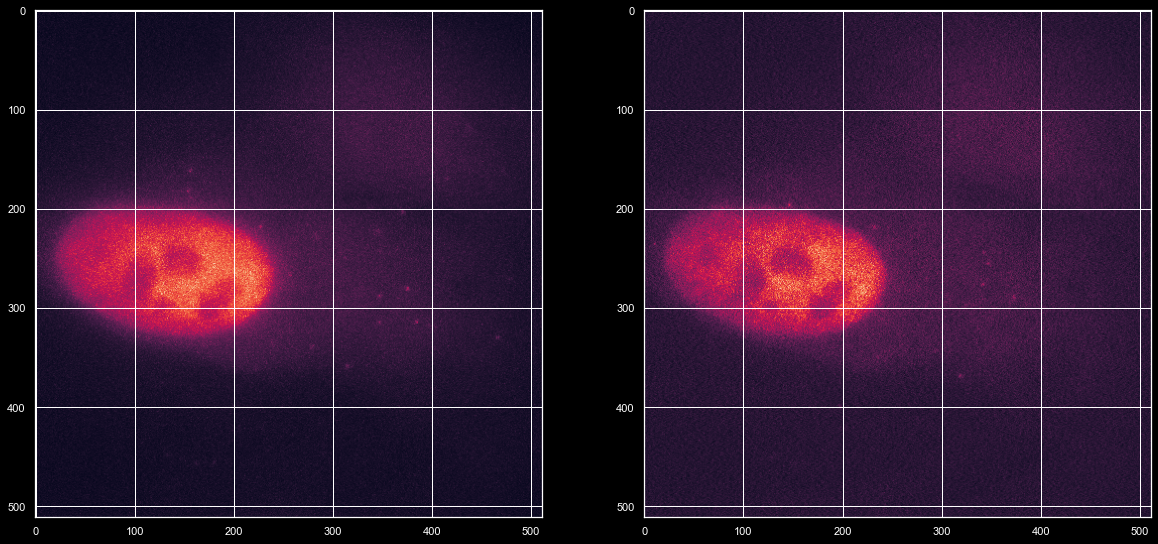

In [7]:
# plotting original image
# Just examining one of the images
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,10))
ax[0].imshow(np.max(img_croparray[0,0,:,:,:,1], axis=0) )
ax[1].imshow(img_croparray[0,1,6,:,:,1])

## Spot detection and tracking


----

Just view video to determine what are the best z planes

In [8]:
viewer = napari.view_image(np.max(img_croparray[0,:,:,:,:,1],axis=1))

In [9]:
tracking_channel = 1  
img_2D = np.amax(img_croparray[0,:,:,:,:,tracking_channel],axis=1)   #(fov, f , z, y, x, ch)
img_2D.shape # ( f, y, x)

(65, 512, 512)

In [10]:
particle_diameter=9

Frame 64: 55 features
Detected spots:  4379


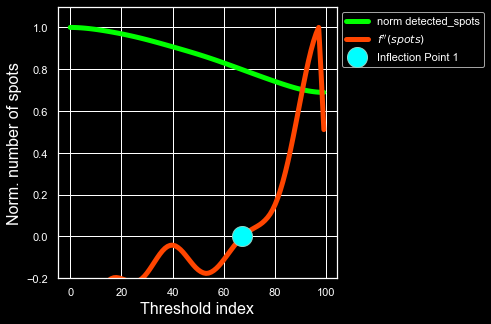

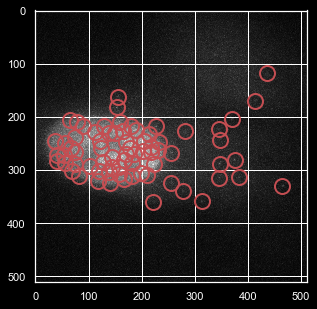

In [12]:
spots_df = ca.detecting_spots(img_2D,particle_diameter=particle_diameter,num_iterations=300,show_plots=True)

In [13]:
spots_df

,fov,n,f,zc,yc,xc,MEAN_INTENSITY
0,0,0,0,0,118,436,1073
1,0,1,0,0,162,156,2048
2,0,2,0,0,170,414,1287
3,0,3,0,0,182,154,1937
4,0,4,0,0,204,370,2142
...,...,...,...,...,...,...,...
4374,0,4374,64,0,315,277,3566
4375,0,4375,64,0,343,266,3696
4376,0,4376,64,0,349,354,1797
4377,0,4377,64,0,371,257,1664


In [14]:
df_temp = spots_df[spots_df['f']==0]

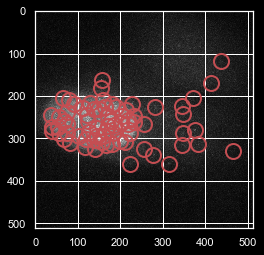

<AxesSubplot:>

In [15]:
tp.annotate(df_temp.rename(columns={'xc':'x','yc':'y','f':'frame'}), img_2D[0])

In [16]:
spots_df

,fov,n,f,zc,yc,xc,MEAN_INTENSITY
0,0,0,0,0,118,436,1073
1,0,1,0,0,162,156,2048
2,0,2,0,0,170,414,1287
3,0,3,0,0,182,154,1937
4,0,4,0,0,204,370,2142
...,...,...,...,...,...,...,...
4374,0,4374,64,0,315,277,3566
4375,0,4375,64,0,343,266,3696
4376,0,4376,64,0,349,354,1797
4377,0,4377,64,0,371,257,1664


In [17]:
spots_df

,fov,n,f,zc,yc,xc,MEAN_INTENSITY
0,0,0,0,0,118,436,1073
1,0,1,0,0,162,156,2048
2,0,2,0,0,170,414,1287
3,0,3,0,0,182,154,1937
4,0,4,0,0,204,370,2142
...,...,...,...,...,...,...,...
4374,0,4374,64,0,315,277,3566
4375,0,4375,64,0,343,266,3696
4376,0,4376,64,0,349,354,1797
4377,0,4377,64,0,371,257,1664


In [18]:
raise

RuntimeError: No active exception to reraise

Now do max-projection on best-z planes

In [ ]:
img_max = np.max(img_croparray[0,:,4:10,:,:,1],axis=1)
img_max.shape

Now you can create a mask to exclude regions, if desired

In [ ]:
viewer = napari.view_image(np.max(img_max,axis=0))  # Max of max, should be a single frame

In [ ]:
from matplotlib.path import Path
import pylab as plt
width, height=512,512

polygon=viewer.layers['Shapes'].data[0]
poly_path=Path(polygon)

x, y = np.mgrid[:height, :width]
coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1))) # coors.shape is (4000000,2)

mask = poly_path.contains_points(coors)
mask = mask.reshape(height, width)
mask2 = np.logical_not(mask)
plt.imshow(mask2*img_max[0])
plt.show()

In [ ]:
# Finding good settings
selected_channel = 0
particle_diameter=7
plt.figure(figsize=(7, 7))
f = tp.locate(img_max[0], particle_diameter,minmass=100)
plt.grid(False)
tp.annotate(f, img_max[0]);

In [ ]:
polygonxy=np.transpose([polygon[:,1],polygon[:,0]]) # Napari has x and y swapped compared to trackpy
poly = Polygon(polygonxy)  # This is a polygon that defines the mask
mypts = np.transpose([f.x,f.y]) # These are the points detected by trackpy
f['In Mask']=[poly.contains(Point(mypts[i])) for i in np.arange(len(mypts))] # Check if pts are on/in polygon mask  
tp.annotate(f[f['In Mask']==False], img_max[0]);

In [ ]:
f['test'] = f.index

In [ ]:
f

In [ ]:
f = tp.batch(img_max, diameter=particle_diameter,minmass=1000)
f.to_csv(os.path.join(dir,img_4D_filename[:-4]+'.csv'))
f.head()

In [ ]:
f

In [ ]:
f_list = []
for i in f.frame:
    f0 = f[f['frame']==i]
    f1 = f0.copy()
    polygonxy=np.transpose([polygon[:,1],polygon[:,0]]) # Napari has x and y swapped compared to trackpy
    poly = Polygon(polygonxy)  # This is a polygon that defines the mask
    mypts = np.transpose([f1.x,f1.y]) # These are the points detected by trackpy
    f1['In Mask']=[poly.contains(Point(mypts[i])) for i in np.arange(len(mypts))] # Check if pts are on/in polygon mask  
    f_list.append(f1)
f_all = pd.concat(f_list)

In [ ]:
f0 = f[f['frame']==0]
f1 = f0.copy()
polygonxy=np.transpose([polygon[:,1],polygon[:,0]]) # Napari has x and y swapped compared to trackpy
poly = Polygon(polygonxy)  # This is a polygon that defines the mask
mypts = np.transpose([f1.x,f1.y]) # These are the points detected by trackpy
f1['In Mask']=[poly.contains(Point(mypts[i])) for i in np.arange(len(mypts))] # Check if pts are on/in polygon mask  
f_list.append(f1)

In [ ]:
f1

Convert f to crop_array format

In [ ]:
#only if you didn't track:
spots = f.copy() # Nice to copy; seems it can cause to overwrite otherwise
spots['id']=spots.index
spots.rename(columns={'x': 'xc','y': 'yc', 'frame': 'f','signal':'signal_tp'}, 
inplace=True, errors='raise')
spots['fov']=0
spots.rename(columns={'particle':'id'})
spots = spots[['fov','id','f','yc','xc','signal_tp']] # keeping signal out of curiousity... want to compare to disk-donut measurements  
spots.head()

## Create Crop Array
____

Create a crop array from 4D movie

In [ ]:
my_ca = ca.create_crop_array(img_croparray,spots,xy_pad=particle_diameter//2+1, dxy=130, dz=500, dt=1, units=['nm','min'])
my_ca

## Quantify signal intensity through time
____

In [ ]:
# Measure signals and plot average signal through time, creating 'best_z' layer and 'signal' layer
ca.measure_signal(my_ca, ref_ch=1, disk_r=3, roll_n=3)

In [ ]:
my_ca.best_z.mean('n').sel(fov=0,ch=1).rolling(t=3,min_periods=1).mean().plot.imshow(col='t',col_wrap=10,robust=True,xticks=[],yticks=[],size=1.5,cmap='gray', vmin=0, vmax =200)

Let's compare our disk-donut 'signal' layer (acquired from 3D image) to trackpy's (acquired from max-projection):

In [ ]:
# Let's compare our intensity numbers to those from trackpy:
my_ca.where(my_ca.signal>0).plot.scatter(x='signal',y='signal_tp',col='ch',hue='ch',colors=['red','limegreen','blue'],levels=[0,1,2,3])

Let's look at average signal vs time

In [ ]:
# Let's look at average signal vs time
start_sig = my_ca.signal.mean('n').sel(t=slice(0,4)).mean('t')
end_sig = 0# my_ca.signal.mean('n').sel(t=slice(15,20)).mean('t')
norm_sig = (my_ca.signal.mean('n') - end_sig)/(start_sig - end_sig)
sns.set_palette(['limegreen','limegreen','blue'])
norm_sig.sel(fov=0,ch=1).plot.line(x='t',hue='ch')

Now let's just use trackpy's values:

In [ ]:
# Let's look at average signal vs time
start_sig = my_ca.signal_tp.mean('n').sel(t=slice(0,4)).mean('t')
end_sig = 0# my_ca.signal_tp.mean('n').sel(t=slice(15,20)).mean('t')
norm_sig = (my_ca.signal_tp.mean('n') - end_sig)/(start_sig - end_sig)
sns.set_palette(['limegreen','limegreen','blue'])
norm_sig.sel(fov=0).plot.line(x='t',hue='ch')

I guess trackpy and the disk donut method do a very good job at getting the intensities of spots. Although note that trackpy got the values from the max-intensity projection. Interesting.

## Visualize crop array montage with Napari
___

Now let's see a montage of the selected spots' best-z planes:

In [ ]:
# view the action of montage showing an n x n crop_array through time
viewer = napari.view_image(ca.montage(my_ca.sel(fov=0,ch=0).best_z,row='n',col='t'),contrast_limits=[60,800])

## Save the crop array
____

In [ ]:
my_ca.to_netcdf(os.path.join(dir,img_4D_filename[:-4]+'.nc') )

## Optional: Create Track Array
___

In [ ]:
# Read in the csv file

In [ ]:
# Note, if you actually wanted to track, you could use the following:
# link tracks
max_distance_movement = 15
track_skip_frames = 3
min_trajectory_length = 10
t = tp.link(f, max_distance_movement, memory=track_skip_frames)
t1 = tp.filter_stubs(t, min_trajectory_length)
t1['particle'] = t1['particle']+1 # VERY IMPORTANT NOT TO HAVE TRACK IDs WITH VALUES = 0 WHEN MAKING CROP ARRAYS AS ZERO IS DEFAULT EMPTY VALUE
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique()) 

In [ ]:
# only if you tracked:
spots = t1.copy()
spots.rename(columns={'x': 'xc','y': 'yc', 'frame': 'f','signal':'signal_tp','particle':'id'}, 
inplace=True, errors='raise')


spots['fov']=0
spots.rename(columns={'particle':'id'})
spots = spots[['fov','id','f','yc','xc','signal_tp']] # keeping signal out of curiousity... want to compare to disk-donut measurements  
spots.head()

In [ ]:
my_ca2 = ca.create_crop_array(img_croparray,spots,xy_pad=particle_diameter//2+1, dxy=130, dz=500, dt=1, units=['nm','min'])

In [ ]:
# Measure signals and plot average signal through time, creating 'best_z' layer and 'signal' layer
ca.measure_signal(my_ca2, ref_ch=1, disk_r=3, roll_n=3)

In [ ]:
import xarray as xr
import pandas as pd
# Since ids correspond to tracks, we can organize tracks in rows  
my_ids = np.unique(my_ca2.id) # Find all unique ids
my_ids = my_ids[1:] # remove the '0' ID used as filler in Crop Arrays
my_ids
# Get a list of xarrays for each unique id 
my_das = []
for i in np.arange(len(my_ids)):
    temp = my_ca2.groupby('id')[my_ids[i]].reset_index('stacked_fov_n_t').reset_coords('n',drop=True).reset_coords('fov',drop=True).swap_dims({'stacked_fov_n_t':'t'})
    my_das.append(temp)
    del temp
# Concatenate the xarrays together to make a new xarray dataset in a track array format (each track on separate row). Here 'n' is replaced by 'tracks'
my_taz = xr.concat(my_das, dim=pd.Index(my_ids, name='track_id'), fill_value=255) # fill_value=0 so keep int instead of moving to floats with NaNs
my_taz = my_taz.transpose('track_id','fov','n','t','z','y','x','ch', missing_dims='ignore') # reorder for napari
my_taz

In [ ]:
# view the action of montage showing an n x n crop_array through time
viewer = napari.view_image(ca.montage(my_taz.sel(ch=1).best_z,row='track_id',col='t'),contrast_limits=[60,800])

In [ ]:
my_taz.isel(track_id=[5,6,9]).sel(ch=1).signal.plot.line(x='t',col='track_id',col_wrap=3)

In [ ]:
my_taz.isel(track_id=[5,6,9])

In [ ]:
my_taz.isel(track_id=[1,3,6,8,17,19]).sel(ch=1).signal.plot.line(x='t',col='track_id',col_wrap=3)

# Trying to track in x, y, and z:

Measure signals and plot average signal through time, creating 'best_z' layer and 'signal' layer

In [ ]:
max_distance_movement = 5
track_skip_frames = 3
my_frame = 15
min_trajectory_length=2
my_list = []
for my_frame in np.arange(len(img_croparray[0,:])): #np.arange(15,16,1):
    f = tp.batch(img_croparray[0,my_frame,:,:,:,1], diameter=7,minmass=1000)
    t1 = tp.link(f, max_distance_movement, memory=track_skip_frames)
    t = tp.filter_stubs(t1, min_trajectory_length)
    sort_t = t.sort_values(['particle']).groupby('particle').aggregate('max').reset_index().rename(columns={'frame':'z'})
    sort_t['t']=my_frame
    my_list.append(sort_t)
my_df = pd.concat(my_list)
my_df.reset_index()

In [ ]:
my_df['raw_mass'].hist()

In [ ]:
plt.figure(figsize=(20,10))
tp.annotate(my_df[(my_df['t']==28)&(my_df['raw_mass']<40000)], img_4D_max_real[28]);

In [ ]:
np.array([len(t[t['particle']==i].x) for i in np.arange(len(t.particle))])

In [ ]:
f[f['frame']==6]